In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from bs4 import BeautifulSoup
from urllib.request import urlopen
import datetime

# Functions

In [2]:
def get_close(tickers,
              start=datetime.date(datetime.date.today().year - 1, 
                datetime.date.today().month, 
                datetime.date.today().day)
                ,end=datetime.date.today()):
    
    data=pd.DataFrame()
    for ticker in tickers:

        try:

            yahoo_data=yf.Ticker(ticker)
            stock_price=yahoo_data.history(start=start,end=end,interval='1d').reset_index()
            stock_price['Date']=stock_price['Date'].dt.tz_localize(None)
            stock_price=stock_price.set_index('Date')
            stock_price[ticker]=stock_price['Close']+stock_price['Dividends'].shift(periods=-1)
            data=pd.concat([data,stock_price[ticker]],axis=1)

        except Exception as e:
            pass
        
    return data

In [3]:
def get_mrat(dataframe,numerator=21,denominator=200):

    mrat=(dataframe.rolling(numerator).mean()/dataframe.rolling(denominator).mean())
    mrat_wo_na=mrat.dropna(how='all')

    month=list(sorted(set(mrat_wo_na.index + pd.offsets.BMonthEnd(0))))
    #month_end=pd.to_datetime(mrat_wo_na.index)
    month = pd.to_datetime(month)

    idx1 = pd.Index(mrat_wo_na.iloc[:-1].index)
    idx2 = pd.Index(month)
    closest_dates = idx1[idx1.get_indexer(idx2, method='nearest')]


    mrat_weights=mrat_wo_na.loc[closest_dates].copy().fillna(0)
    
    mrat_weights['Total']=mrat_weights.sum(axis=1)

    for col in mrat_weights.columns:
        mrat_weights[col]=mrat_weights[col]/mrat_weights['Total']

    mrat_weights=mrat_weights.drop(columns='Total')
    mrat_weights_dict=mrat_weights.transpose().to_dict()

    dates_end=list(mrat_weights.index)
    dates_end.insert(0,dataframe.index[0])
    dates_end.append(dataframe.index[-1])
    dates_end=list(set(dates_end))
    
    return mrat_weights,sorted(dates_end)

In [4]:
def get_portfolios(mrat_weights,dates_end,dataframe,weight_dict,
                   numbers_of_stocks=50,
                   investment_amount=10000,
                   transaction_fee=0.005):
    tracking={}
    portfolio={}
    initial_amount=investment_amount
    perf=dataframe.pct_change()
    
    for i in range(len(dates_end)-1):
        
        print(dates_end[i],investment_amount,investment_amount/initial_amount)

        
        temp=dataframe.loc[dates_end[i]:dates_end[i+1]].copy()
        initial_price=temp.iloc[0].to_dict()

        if dates_end[i]>dates_end[0]:

            top50=mrat_weights.loc[dates_end[i]].sort_values(ascending=False)[:numbers_of_stocks]
            top_50_rebased=top50/top50.sum()
            top_50_dict=top_50_rebased.to_dict()

            weight_dict={}

            for key in temp.columns:

                if key in top_50_dict: 
                    weight_dict[key]=top_50_dict[key]
                else:
                    weight_dict[key]=0
                    
                    
        weight_vec=np.array(list(weight_dict.values()))
        
        inital_investment_per_stock={}
        shares={}

        for col in temp.columns:
            
            weighted_perf=weight_vec*perf.loc[dates_end[i]]
            
            inital_investment_per_stock[col]=weight_dict[col]*investment_amount*(1+weighted_perf.sum())
            shares[col]=inital_investment_per_stock[col]*(1-transaction_fee)/initial_price[col]

        tracking[dates_end[i]]=(weight_dict,shares,investment_amount,initial_price)

        temp=temp*shares    
        portfolio[dates_end[i]]=temp
        investment_amount=temp.iloc[-1].sum()
        
    
    temp=dataframe.loc[dates_end[-2]:]*shares
    portfolio[dates_end[-1]]=temp
        

    return portfolio,tracking


In [5]:
def get_pnl(portfolios):

    pnl={}

    keys=list(portfolio.keys())
    for i in range(len(keys)):

        if i>0:
            pnl[keys[i]]=portfolio[keys[i]].iloc[-1]-portfolio[keys[i]].iloc[0]

        else:
            
            pnl[keys[0]]=portfolio[keys[0]].iloc[-1]-portfolio[keys[0]].iloc[0]
    
    pnl_dataframe=pd.DataFrame(pnl).cumsum(axis=1).T
    
    return pnl_dataframe.iloc[:-2]

# Dataset

In [6]:
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
table = pd.read_html(url)
df = table[0]
tickers=df['Symbol'].tolist()

end_date = datetime.datetime.now().strftime("%Y-%m-%d")
start_date = (datetime.datetime.now() - datetime.timedelta(days=365)).strftime("%Y-%m-%d")
analysis_start_date = (datetime.datetime.now() - datetime.timedelta(days=365*4)).strftime("%Y-%m-%d")

dataframe=get_close(tickers,start=analysis_start_date,end=end_date)
dataframe.index=pd.to_datetime(dataframe.index)

BRK.B: No timezone found, symbol may be delisted
BF.B: No price data found, symbol may be delisted (1d 2020-12-14 -> 2024-12-13)


In [7]:
sp500=get_close(['SPY'],start=analysis_start_date,end=end_date)

# Analysis

In [8]:
weight_dict={col: 1/dataframe.shape[1] for col in dataframe.columns}
mrat_weights,dates_end=get_mrat(dataframe,numerator=21,denominator=200)

In [9]:
dates_end

[Timestamp('2020-12-14 00:00:00'),
 Timestamp('2021-09-30 00:00:00'),
 Timestamp('2021-10-29 00:00:00'),
 Timestamp('2021-11-30 00:00:00'),
 Timestamp('2021-12-31 00:00:00'),
 Timestamp('2022-01-31 00:00:00'),
 Timestamp('2022-02-28 00:00:00'),
 Timestamp('2022-03-31 00:00:00'),
 Timestamp('2022-04-29 00:00:00'),
 Timestamp('2022-05-31 00:00:00'),
 Timestamp('2022-06-30 00:00:00'),
 Timestamp('2022-07-29 00:00:00'),
 Timestamp('2022-08-31 00:00:00'),
 Timestamp('2022-09-30 00:00:00'),
 Timestamp('2022-10-31 00:00:00'),
 Timestamp('2022-11-30 00:00:00'),
 Timestamp('2022-12-30 00:00:00'),
 Timestamp('2023-01-31 00:00:00'),
 Timestamp('2023-02-28 00:00:00'),
 Timestamp('2023-03-31 00:00:00'),
 Timestamp('2023-04-28 00:00:00'),
 Timestamp('2023-05-31 00:00:00'),
 Timestamp('2023-06-30 00:00:00'),
 Timestamp('2023-07-31 00:00:00'),
 Timestamp('2023-08-31 00:00:00'),
 Timestamp('2023-09-29 00:00:00'),
 Timestamp('2023-10-31 00:00:00'),
 Timestamp('2023-11-30 00:00:00'),
 Timestamp('2023-12-

In [10]:
portfolio,tracking=get_portfolios(investment_amount=100,dataframe=dataframe,numbers_of_stocks=15,weight_dict=weight_dict,
                                  mrat_weights=mrat_weights,dates_end=dates_end,
                                  transaction_fee=0.005)

2020-12-14 00:00:00 100 1.0
2021-09-30 00:00:00 119.74928151380944 1.1974928151380944
2021-10-29 00:00:00 131.75970011929405 1.3175970011929405
2021-11-30 00:00:00 130.68073843898875 1.3068073843898875
2021-12-31 00:00:00 125.27978069847373 1.2527978069847372
2022-01-31 00:00:00 112.59387868092495 1.1259387868092494
2022-02-28 00:00:00 119.05700955723697 1.1905700955723697
2022-03-31 00:00:00 138.2604888048781 1.382604888048781
2022-04-29 00:00:00 133.2084851270137 1.3320848512701369
2022-05-31 00:00:00 141.86669233029912 1.4186669233029912
2022-06-30 00:00:00 113.27251191184376 1.1327251191184375
2022-07-29 00:00:00 121.78357537758437 1.2178357537758437
2022-08-31 00:00:00 122.96656484197092 1.2296656484197093
2022-09-30 00:00:00 116.1625581932785 1.161625581932785
2022-10-31 00:00:00 134.11860665487166 1.3411860665487165
2022-11-30 00:00:00 144.2934533375878 1.442934533375878
2022-12-30 00:00:00 136.1768244318172 1.361768244318172
2023-01-31 00:00:00 142.72307764290196 1.427230776429

In [11]:
pd.DataFrame(tracking[dates_end[-2]][0].items()).set_index(0).sort_values(by=1,ascending=False).iloc[:20]

,1
0,
PLTR,0.087354
TPL,0.076985
AXON,0.074964
UAL,0.074331
VST,0.070558
TSLA,0.069293
RCL,0.063755
TRGP,0.062924
FICO,0.062337


In [12]:
investment_amount=100
shares={}
for col in dataframe:
    
    shares[col]=(weight_dict[col]*investment_amount)/dataframe.iloc[0][col]

In [13]:
equal_weight=shares*dataframe

In [14]:
pnl=get_pnl(portfolio)
pnl['Total']=pnl.sum(axis=1)
pnl_pct=pnl.copy()

for col in pnl_pct.columns:
    pnl_pct[col]/=pnl_pct['Total']
    
pnl_contrib=pd.DataFrame(pnl_pct.iloc[-1].sort_values(ascending=False))
pnl_amount=pd.DataFrame(pnl.iloc[-1].sort_values(ascending=False))


In [15]:
pnl_contrib

,2024-11-29
Total,1.000000
SMCI,0.124563
NVDA,0.117403
PLTR,0.106131
VST,0.073818
...,...
UHS,-0.015857
NCLH,-0.016697
AMD,-0.018515
ENPH,-0.021651


In [16]:
historical_portfolio=pd.DataFrame()
performance=pd.DataFrame()
for key in portfolio.keys():
    historical_portfolio=historical_portfolio.combine_first(portfolio[key])
    

<AxesSubplot:>

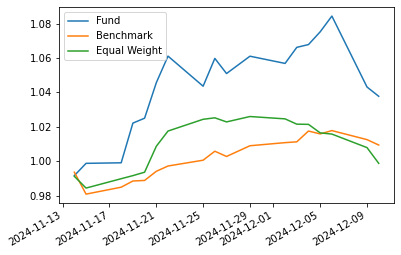

In [17]:
performance['Fund']=historical_portfolio.sum(axis=1)
performance['Benchmark']=sp500
performance['Equal Weight']=equal_weight.sum(axis=1)
performance_pct=performance.copy()
performance_pct=performance_pct.pct_change()

(1+performance_pct.iloc[-20:-2]).cumprod().plot()

In [18]:
metrics={}
metrics['Tracking Error']=(performance_pct['Fund']-performance_pct['Benchmark']).std()*np.sqrt(252)
metrics['Fund Vol']=performance_pct['Fund'].std()*np.sqrt(252)
metrics['Bench Vol']=performance_pct['Benchmark'].std()*np.sqrt(252)
metrics['Fund Return']=performance['Fund'].iloc[-2]/performance['Fund'].iloc[0]
metrics['Bench Return']=performance['Benchmark'].iloc[-2]/performance['Benchmark'].iloc[0]
metrics['Sharpe Ratio']=metrics['Fund Return']/metrics['Fund Vol']

In [19]:
indicators=pd.DataFrame(metrics.values(),index=metrics.keys(),columns=['Indicators'])
indicators

,Indicators
Tracking Error,0.543883
Fund Vol,0.570732
Bench Vol,0.164554
Fund Return,2.854452
Bench Return,1.765404
Sharpe Ratio,5.001388


# Manual Testing

initial_price=dataframe.iloc[0].to_dict()
weight_dict={}
inital_investment_per_stock={}
shares={}
initial_amount=100

perf=dataframe.pct_change()
for col in dataframe.columns:
    
    weight_dict[col]=1/dataframe.shape[1]

    inital_investment_per_stock[col]=weight_dict[col]*initial_amount
    shares[col]=inital_investment_per_stock[col]*(1-0.005)/initial_price[col]
    

t=(dataframe*shares).sum(axis=1).loc[dates_end[1]]
i=1
t

top50=mrat_weights.loc[dates_end[i]].sort_values(ascending=False)[:20]
top_50_rebased=top50/top50.sum()
top_50_rebased=top_50_rebased.to_dict()

inital_investment_per_stock={}
initial_investment=t
shares={}
initial_price=dataframe.loc[dates_end[i]].to_dict()
#tracking[1][3]

weight_dict={}

for col in dataframe.columns:    

    if col in top_50_rebased:
        
        weight_dict[col]=top_50_rebased[col]
    else:
        weight_dict[col]=0
        
weight_vec=np.array(list(weight_dict.values()))


for col in dataframe.columns:    

    inital_investment_per_stock[col]=weight_dict[col]*initial_investment*(1+(perf.loc[dates_end[i]]*weight_vec).sum())
    shares[col]=inital_investment_per_stock[col]*(1-0.005)/initial_price[col]

i=i+1

t=(dataframe*shares).sum(axis=1).loc[dates_end[i]]
t